In [74]:
%reset -f

import warnings
warnings.filterwarnings(action="once")

from os import listdir
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# to compute time of pipeline
from time import time, strftime, gmtime

from preprocess_images import *
from sift_functions import *

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


##### Setting paths

In [75]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
path_images = "./dataset/images/"
input_filename = "data_images.csv"
input_file = "{}{}".format(input_path, input_filename)

image_features_path = "./dataset/image_features/"

In [76]:
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


##### Loading the dataset containing information about the images

In [77]:
data_images = pd.read_csv(input_file)
data_images.head()

,product_name,image_path,category,target
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


# SIFT

In this notebook, we are going to create **features** for each of 1050 images that we have. These features generated thanks to SIFT algorithm are **bag-of-visual-words**.

Then, we will use a KMeans clustering on these **bag-of-visual-words** to separate the images into 7 categories.

We will display the clusters compared to the real categories using a 2D representation of t-SNE.


#### Getting the list of categories and checking the dataset.

In [78]:
list_labels = data_images["category"].unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [79]:
display(data_images.groupby("target").count())
print("The data is balanced !")

,product_name,image_path,category
target,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


The data is balanced !


### Displaying some example of images per category

Home Furnishing
-------
For this category, we have 150 images.


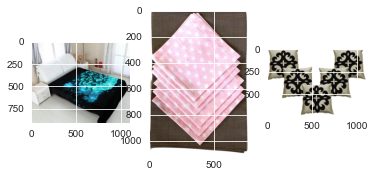

Baby Care
-------
For this category, we have 150 images.


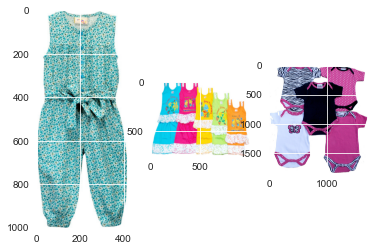

Watches
-------
For this category, we have 150 images.


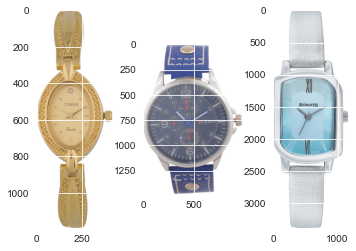

Home Decor & Festive Needs
-------
For this category, we have 150 images.


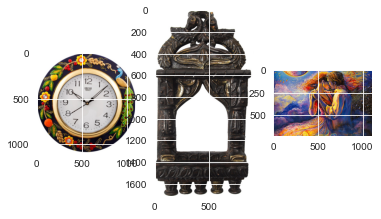

Kitchen & Dining
-------
For this category, we have 150 images.


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


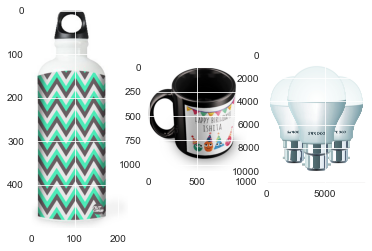

Beauty and Personal Care
-------
For this category, we have 150 images.


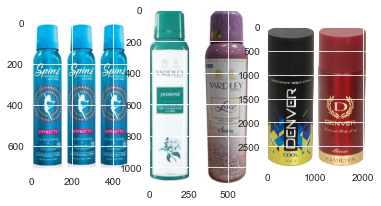

Computers
-------
For this category, we have 150 images.


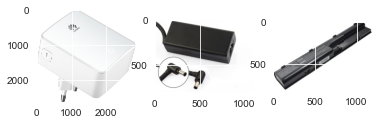

In [80]:
n_categories = len(list_labels)
n_photos = len(list_photos)

display_images_per_category(list_labels, data_images, path_images, "image_path", "category", list_photos)

Though 7 categories do not enable to completely separate the products, we have images that are correctly labeled.

### Getting SIFT keypoints for one image

* The image below has 4150 keypoints
* Each keypoint is a vector of length 128

In [81]:
filename = path_images + list_photos[0]
img = Image.open(filename)

# Displaying the image
#img.show()

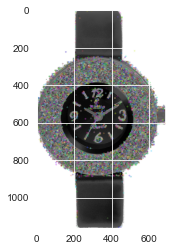

SIFT keypoints :  (4150, 128)

[[  3.  52. 133. ...   4.  30.  22.]
 [ 11.   1.   4. ...   0.   0.   0.]
 [  0.   0.   1. ...  14.   2.   4.]
 ...
 [ 14.   3.   5. ...   0.   0.   0.]
 [ 34.  18.   9. ...   0.   2.   3.]
 [  9. 128.  45. ...   0.   0.   0.]]


In [82]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path_images + list_photos[0], 0)  # convert in gray
image = cv2.equalizeHist(image)  # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("SIFT keypoints : ", des.shape)
print()
print(des)


# I - Preprocessing the images using SIFT

### 1) Creating SIFT keypoints for each image

* For each image : converting to greyscale and equalization
* Creating a list of keypoints per image ("sift_keypoints_by_img") that will be used to create the images' histograms.
* Creating a list of keypoints for all the images ("sift_keypoints_all") that will be used to create clusters (to get **bag-of-visual-words**)

In [83]:
sift_keypoints_by_img, sift_keypoints_all = generate_keypoints(data_images, "image_path", path_images)
save_features(image_features_path, "keypoints_by_img.npz", sift_keypoints_by_img)
save_features(image_features_path, "keypoints_all.npz", sift_keypoints_all)

100%|██████████| 1050/1050 [08:00<00:00,  2.19it/s] 



Number of keypoints :  (517351, 128)
SIFT descriptor processing time :           480.69 seconds


In [84]:
# we load the keypoints saved locally
sift_keypoints_all = load_features(image_features_path, "keypoints_all.npz")
sift_keypoints_all

array([[ 12.,   7.,   3., ...,   0.,   0.,   4.],
       [  5.,   0.,   0., ...,   0.,   1.,  30.],
       [  1.,   2.,   1., ...,   2.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  21.,  56.,  35.],
       [  3.,  28., 123., ...,   0.,   0.,   2.],
       [ 21.,  98.,  22., ...,   0.,   0.,   4.]], dtype=float32)

In [85]:
sift_keypoints_by_img = load_features(image_features_path, "keypoints_by_img.npz")
sift_keypoints_by_img

array([array([[12.,  7.,  3., ...,  0.,  0.,  4.],
              [ 5.,  0.,  0., ...,  0.,  1., 30.],
              [ 1.,  2.,  1., ...,  2.,  0.,  0.],
              ...,
              [30.,  3.,  0., ..., 29.,  1.,  4.],
              [24.,  9.,  1., ...,  1.,  0.,  0.],
              [82., 13.,  2., ...,  1.,  1., 13.]], dtype=float32),
       array([[  3.,   6.,   0., ...,   0.,   0.,   2.],
              [  6.,  20.,  27., ...,  65.,  55.,   9.],
              [121.,  36.,   0., ...,   0.,   0.,   2.],
              ...,
              [ 86.,  36.,  30., ...,   5.,  15., 118.],
              [  8.,  24.,  19., ...,   1.,   1.,  27.],
              [ 24.,  23.,   2., ...,  17.,   0.,   0.]], dtype=float32),
       array([[  3.,   2.,   0., ...,   0.,   0.,  18.],
              [ 80.,   1.,   0., ...,   1.,   0.,   1.],
              [  1.,  15., 119., ...,  81.,  78.,   0.],
              ...,
              [  0.,   0.,  14., ...,   0.,   0.,   3.],
              [  0.,   0.,   0., 

### 2) Creating clusters of keypoints : bag-of-visual-words
* Using MiniBatchKMeans to reduce processing time

In [86]:
kmeans = get_bag_of_images(sift_keypoints_all)

Number of clusters estimated :  719
Creating of 719 clusters of keypoints ...
KMeans processing time :            11.21 seconds


### 3) Creating features for each image
* For each image :
   - predicting the number of the cluster of each keypoint
   - creating a histogram (counting for each cluster number the number of keypoints of the image

In [87]:
im_features = get_images_features(sift_keypoints_by_img, kmeans)

100%|██████████| 1050/1050 [00:02<00:00, 372.67it/s]

Creation of histograms processing time :             2.82 seconds


## II - Reducing dimensions and visualization

### PCA
* PCA generates uncorrelated features, to reduce the dimension of the dataset while keeping a high explained variance (99% in our case).
* We will get a better separation of the data when using t-SNE later on and better processing times.

In [88]:
im_features.shape

(1050, 719)

In [89]:
feat_pca = get_pca_for_features(im_features)

Shape of dataset before PCA :  (1050, 719)
Shape of dataset after PCA with 99% of explained variance :  (1050, 498)


### t-SNE
* Reducing the dimension of the dataset to 2 t-SNE components to get a 2D visualization of the images.

In [90]:
X_tsne, df_tsne = get_tsne(feat_pca, data_images, "category")

C:\Users\oumei\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


### Visual analysis : displaying t-SNE according to the images' categories
* We can see below that the SIFT method doesn't enable us to separate the categories of the products.

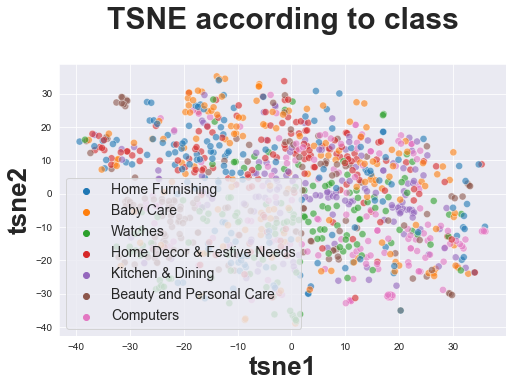

In [91]:
display_tsne(df_tsne, "class")

### Comparing real categories and the clusters

####  Creating a clustering from t-SNE

In [92]:
cls = clustering_tsne(X_tsne)
df_tsne = add_cluster_tsne(df_tsne, cls)

(1050, 4)


####  Displaying the images according to their cluster and computing ARI real categories and the cluster categories
* We get a low ARI score

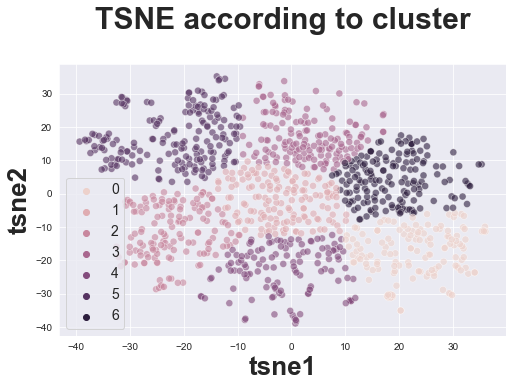

ARI :  0.05777523226425486


In [93]:
display_tsne(df_tsne, "cluster")
print_ari_score(data_images["target"], cls)

#### Analysis per category
* We have tried below to associate the number of the clusters to the real categories but that is not a precise method.

<AxesSubplot:ylabel='class'>

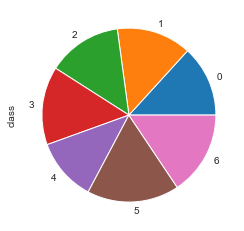

In [101]:
# we count the number of images per cluster
df_tsne.groupby("cluster").count()["class"].plot(kind="pie")

In [95]:
real_labels_list = data_images.target.tolist()

In [96]:
conf_mat = confusion_matrix(y_true=real_labels_list,y_pred= cls.labels_)
print(conf_mat)

[[20 16 10 26 11 41 26]
 [12 16 62 17 13 17 13]
 [54 12 13 20 20  7 24]
 [ 6 16  6 46 11 41 24]
 [16 11 12 17 23 55 16]
 [15 35 12 19 15 13 41]
 [16 40 30  8 30  6 20]]


In [97]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print(corresp)
    corresp = [2, 6, 1, 3, 0, 4, 5]  # [2 6 1 3 6 4 5]
    print("Correspondance of the clusters : ", corresp)
    print("This is not a precise method")
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])

    return labels['y_pred_transform']

In [98]:
labels = data_images["target"]
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(classification_report(labels, cls_labels_transform))

[2 6 1 3 6 4 5]
Correspondance of the clusters :  [2, 6, 1, 3, 0, 4, 5]
This is not a precise method
[[11 10 20 26 41 26 16]
 [13 62 12 17 17 13 16]
 [20 13 54 20  7 24 12]
 [11  6  6 46 41 24 16]
 [23 12 16 17 55 16 11]
 [15 12 15 19 13 41 35]
 [30 30 16  8  6 20 40]]

              precision    recall  f1-score   support

           0       0.09      0.07      0.08       150
           1       0.43      0.41      0.42       150
           2       0.39      0.36      0.37       150
           3       0.30      0.31      0.30       150
           4       0.31      0.37      0.33       150
           5       0.25      0.27      0.26       150
           6       0.27      0.27      0.27       150

    accuracy                           0.29      1050
   macro avg       0.29      0.29      0.29      1050
weighted avg       0.29      0.29      0.29      1050



<AxesSubplot:>

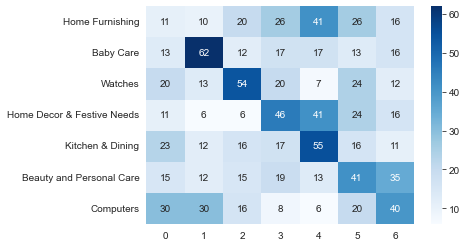

In [99]:
df_cm = pd.DataFrame(conf_mat, index=[label for label in list_labels],
                     columns=[i for i in "0123456"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Conclusion
Classifying the products based on their images and using SIFT algorithm doesn't seem promising.
We have to try other method such as CNN Transfer Learning.

In [100]:
# End of notebook time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))

computing time : 608.643314 sec
computing time : 00:10:08
